# Model Training, Testing and Evaluation

This notebook aims to build a model capable of differentiating between Sincere and Insincere questions. We will also see the effect of stemming, or not, a word, for this analysis.

<br>

### Training

First, a full matrix was created from the sparse matrix, to be able to count the occurrences, in each question, for every word present in the vocabulary; afterwards, I was able to calculate the probability of every word, in every question, being present in Sincere and Insincere questions. With these probabilities, it is possible to calculate, for every question, a probability of a question to be either Sincere or Insincere, providing a Decision Boundary, in this case, 50%, meaning that if the probability of a question to be Insincere is higher than 50%, it would be classified as Insincere.

Since this is a Naive Bayes Classifier, we assume independence between features, the frequency of the words.

The logic behind calculating the probability of a question to be Insincere is as follows:

<br>

$$ P(Insincere \, | \, Token) = \frac{P(Token \, | \, Insincere) \, (P(Insincere))} {P(Token)} $$

<br>

This translates as the probability of a question being insincere given it contains a certain word is equal to the probability of a word being present in an insincere question, times the probability of a question being insincere, dividing by the probability of a word being present in all questions.

Every question's probability of being Insincere is a sum of the probabilities for all the words it contains.

A Laplace Smoothing Technique was used in order to ensure that there are no zeros in the numerator and denominator.

I'm also using a log transformation to more easily calculate and better visualize the data.

<br>

### Testing

After testing the model with the test dataset, we got the following results for both models:

* Stemmed Model:
    * True Positives: 106
    * True Negatives: 3477
    * False Positives: 147
    * False Negatives: 131



* Not Stemmed Model:
    * True Positives: 99
    * True Negatives: 3464
    * False Positives: 128
    * False Negatives: 137

<br>

With these parameters, the following metrics were calculated:

* Stemmed Model:
    * Model Accuracy is: 92.8
    * Recall Score: 44.73
    * Precision Score: 41.9
    * F-Score: 43.27



* Not Stemmed Model:
    * Model Accuracy is: 93.08
    * Recall Score: 41.95
    * Precision Score: 43.61
    * F-Score: 42.76

<br>

### Evaluation

As we can see from the testing results, both models are not very good at predicting the type of question.

As the differences between models are not significant, for this model, a stemmed or not stemmed version seems to be indifferent. Although probably not statistically significant, the Stemmed Model tends to more correctly classify questions as Insincere, and the Not Stemmed Model appears to be better and correctly classifying Sincere questions.

The accuracy is indeed high, but this comes from the fact that the data is unbalanced; as there are not many Insincere questions, since the model assumes a Sincere question by default, it is normal that most question will be correctly classified.

However, the other metrics show the not so good performance in differentiating questions. Both Recall and Precision (and, consequently, the F-Score) are low. This comes from the fact that the model has a small percentage of True Positives; many Insincere questions pass through the filter, and some Sincere questions are wrongly classified as Insincere.

As such, I'm concluding that this type of analysis is not suited to differentiate Sincere and Insincere questions. I'm assuming two reasons for this to happen, first, the sincerity of a question is probably best analyzed not from the words it is using, but from the meaning they are trying to convey, second, it could be that the classification of the questions was not done in the best way possible, and, as such, is introducing a bias into the model.

It could also be interesting to train a model with a more balanced dataset.

Below there is a graphic to better visualize the performance of the Stemmed Model:

<br>

![image3.png](../static/stemmed-model-performance.png)
<p><center>Image 4: Stemmed Model Performance</center></p>

In [1]:
# IMPORTS
import pandas as pandas
import numpy as numpy
import matplotlib.pyplot as pyplot
import seaborn as seaborn

In [2]:
# CONSTANTS
STEMMED_WORDS_BACKUP = '../data/stemmed-words.json'
NOT_STEMMED_WORDS_BACKUP = '../data/not-stemmed-words.json'
NOT_STEMMED_WORDS_VOCABULARY_BACKUP = '../data/not-stemmed-vocabulary.json'
STEMMED_WORDS_VOCABULARY_BACKUP = '../data/stemmed-vocabulary.json'
STEMMED_SPARSE_TEST = '../data/stemmed-sparse-matrix-test.json'
STEMMED_SPARSE_TRAIN = '../data/stemmed-sparse-matrix-train.json'
NOT_STEMMED_SPARSE_TEST = '../data/not-stemmed-sparse-matrix-test.json'
NOT_STEMMED_SPARSE_TRAIN = '../data/not-stemmed-sparse-matrix-train.json'
TRAIN_FULL_STEMMED = '../data/train-full-stemmed.json'
TEST_FULL_STEMMED = '../data/test-full-stemmed.json'
TRAIN_FULL_NOT_STEMMED = '../data/train-full-not-stemmed.json'
TEST_FULL_NOT_STEMMED = '../data/test-full-not-stemmed.json'
TRAIN_FULL_STEMMED = '../data/train-full-stemmed.json'
TEST_FULL_STEMMED = '../data/test-full-stemmed.json'
TRAIN_FULL_NOT_STEMMED = '../data/train-full-not-stemmed.json'
TEST_FULL_NOT_STEMMED = '../data/test-full-not-stemmed.json'

In [3]:
# DATA IMPORTS
notStemmedSparseMatrixTest = pandas.read_json(NOT_STEMMED_SPARSE_TEST).to_numpy()
notStemmedSparseMatrixTrain = pandas.read_json(NOT_STEMMED_SPARSE_TRAIN).to_numpy()
stemmedSparseMatrixTest = pandas.read_json(STEMMED_SPARSE_TEST).to_numpy()
stemmedSparseMatrixTrain = pandas.read_json(STEMMED_SPARSE_TRAIN).to_numpy()
stemmedVocabulary = pandas.read_json(STEMMED_WORDS_VOCABULARY_BACKUP)
notStemmedVocabulary = pandas.read_json(NOT_STEMMED_WORDS_VOCABULARY_BACKUP)

In [4]:
# create a full matrix from a sparse matrix
def createFullMatrix(matrix,
                     vocabularySize,
                     questionIdIndex = 0,
                     wordIdIndex = 1,
                     labelIndex = 2,
                     ocurrencesIndex = 3):
    
    
    # variables
    # create a full matrix populated with zeros
    columnNames = ['QUESTION_ID'] + ['LABEL'] + list(range(0, vocabularySize))
    indexNames = numpy.unique(matrix[:, 0])
    fullMatrix = pandas.DataFrame(index = indexNames, columns = columnNames)
    fullMatrix.fillna(value = 0, inplace = True)
    
    
    # loop through every word in the sparse matrix
    for i in range(matrix.shape[0]):
        
        
        # store values in variables
        questionId = matrix[i][questionIdIndex]
        wordId = matrix[i][wordIdIndex]
        label = matrix[i][labelIndex]
        ocurrences = matrix[i][ocurrencesIndex]
        
        
        # update full matrix
        fullMatrix.at[questionId, 'QUESTION_ID'] = questionId
        fullMatrix.at[questionId, 'LABEL'] = label
        fullMatrix.at[questionId, wordId] = ocurrences
    
    
    # set index, delete email id column
    fullMatrix.set_index('QUESTION_ID', inplace = True)
    
    
    # return
    return fullMatrix

In [5]:
%%time


# CREATE FULL MATRIX FROM SPARSE MATRIX
testFullMatrixStemmed = createFullMatrix(stemmedSparseMatrixTest, stemmedVocabulary.size)
trainFullMatrixStemmed = createFullMatrix(stemmedSparseMatrixTrain, stemmedVocabulary.size)
testFullMatrixNotStemmed = createFullMatrix(notStemmedSparseMatrixTest, notStemmedVocabulary.size)
trainFullMatrixNotStemmed = createFullMatrix(notStemmedSparseMatrixTrain, notStemmedVocabulary.size)


# # SAVE DATA
# testFullMatrixStemmed.to_json(TEST_FULL_STEMMED)
# trainFullMatrixStemmed.to_json(TRAIN_FULL_STEMMED)
# testFullMatrixNotStemmed.to_json(TEST_FULL_STEMMED)
# trainFullMatrixNotStemmed.to_json(TRAIN_FULL_STEMMED)

CPU times: user 39.2 s, sys: 1.29 s, total: 40.5 s
Wall time: 40.5 s


In [6]:
# PROBABILITIES
numberOfQuestions = trainFullMatrixStemmed['LABEL'].size
numberOfInsincereQuestions = trainFullMatrixStemmed['LABEL'].sum()
probabilityOfInsincereQuestion = numberOfInsincereQuestions / numberOfQuestions
probabilityOfSincereQuestion = 1 -probabilityOfInsincereQuestion
print(f'Probability of a Question Being Sincere: {round(probabilityOfSincereQuestion * 100, 2)}%')
print(f'Probability of a Question Being Insincere: {round(probabilityOfInsincereQuestion * 100, 2)}%')

Probability of a Question Being Sincere: 93.32%
Probability of a Question Being Insincere: 6.68%


In [7]:
# TOTAL NUMBER OF WORDS FOR BOTH MODELS


# stemmed model
ocurrencesMatrixStemmed = trainFullMatrixStemmed.drop('LABEL', axis = 1)
wordsPerQuestionStemmed = ocurrencesMatrixStemmed.sum(axis = 1)
totalWordsStemmed = wordsPerQuestionStemmed.sum()
print('Total Number of Stemmed Words:', totalWordsStemmed)


# not stemmed model
ocurrencesMatrixNotStemmed = trainFullMatrixNotStemmed.drop('LABEL', axis = 1)
wordsPerQuestionNotStemmed = ocurrencesMatrixNotStemmed.sum(axis = 1)
totalWordsNotStemmed = wordsPerQuestionNotStemmed.sum()
print('Total Number of Not Stemmed Words:', totalWordsNotStemmed)

Total Number of Stemmed Words: 47557
Total Number of Not Stemmed Words: 41994


In [8]:
# TOTAL WORDS IN DIFFERENT QUESTIONS FOR BOTH MODELS


# stemmed model
wordsInSincereStemmed = wordsPerQuestionStemmed[trainFullMatrixStemmed['LABEL']  == 0].sum()
wordsInInsincereStemmed = wordsPerQuestionStemmed[trainFullMatrixStemmed['LABEL']  == 1].sum()
print('Stemmed Words in Sincere Questions:', wordsInSincereStemmed)
print('Stemmed Words in Insincere Questions:', wordsInInsincereStemmed, '\n')


# not stemmed model
wordsInSincereNotStemmed = wordsPerQuestionNotStemmed[trainFullMatrixNotStemmed['LABEL']  == 0].sum()
wordsInInsincereNotStemmed = wordsPerQuestionNotStemmed[trainFullMatrixNotStemmed['LABEL']  == 1].sum()
print('Not Stemmed Words in Sincere Questions:', wordsInSincereNotStemmed)
print('Not Stemmed Words in Insincere Questions:', wordsInInsincereNotStemmed)

Stemmed Words in Sincere Questions: 42883
Stemmed Words in Insincere Questions: 4674 

Not Stemmed Words in Sincere Questions: 37802
Not Stemmed Words in Insincere Questions: 4192


In [9]:
# WORD OCURRENCES FOR BOTH MODELS
# using laplace smoothing, to ensure there is no zero in the numerator


# stemmed model
wordOcurrencesInInsincereStemmed = ocurrencesMatrixStemmed.loc[trainFullMatrixStemmed['LABEL'] == 1].sum(axis = 0) + 1
wordOcurrencesInSincereStemmed = ocurrencesMatrixStemmed.loc[trainFullMatrixStemmed['LABEL'] == 0].sum(axis = 0) + 1
wordOcurrencesInQuestionsStemmed = ocurrencesMatrixStemmed.sum(axis = 0) + 1


# not stemmed model
wordOcurrencesInInsincereNotStemmed = ocurrencesMatrixNotStemmed.loc[trainFullMatrixNotStemmed['LABEL'] == 1].sum(axis = 0) + 1
wordOcurrencesInSincereNotStemmed = ocurrencesMatrixNotStemmed.loc[trainFullMatrixNotStemmed['LABEL'] == 0].sum(axis = 0) + 1
wordOcurrencesInQuestionsNotStemmed = ocurrencesMatrixNotStemmed.sum(axis = 0) + 1

In [10]:
# PROBABILITY OF A WORD BEING IN EACH QUESTION FOR BOTH MODELS
# because of laplace smoothing, we added 1 VOCABULARY_SIZE times, so we have to add VOCABULARY_SIZE also in the denominator
VOCABULARY_SIZE_STEMMED = stemmedVocabulary.size
VOCABULARY_SIZE_NOT_STEMMED = notStemmedVocabulary.size


# stemmed model
insincereStemmedWordProbability = wordOcurrencesInInsincereStemmed / (wordsInInsincereStemmed + VOCABULARY_SIZE_STEMMED)
sincereStemmedWordProbability = wordOcurrencesInSincereStemmed / (wordsInSincereStemmed + VOCABULARY_SIZE_STEMMED)
wordStemmedProbability = wordOcurrencesInQuestionsStemmed / (totalWordsStemmed + VOCABULARY_SIZE_STEMMED)
print('QC, is the sum of insincereStemmedWordProbability equal to 1? ', insincereStemmedWordProbability.sum() == 1, sep = '')
print('QC, is the sum of sincereStemmedWordProbability equal to 1? ', sincereStemmedWordProbability.sum() == 1, sep = '')
print('QC, is the sum of wordStemmedProbability equal to 1? ', wordStemmedProbability.sum() == 1, '\n', sep = '')


# not stemmed model
insincereNotStemmedWordProbability = wordOcurrencesInInsincereNotStemmed / (wordsInInsincereNotStemmed + VOCABULARY_SIZE_NOT_STEMMED)
sincereNotStemmedWordProbability = wordOcurrencesInSincereNotStemmed / (wordsInSincereNotStemmed + VOCABULARY_SIZE_NOT_STEMMED)
wordNotStemmedProbability = wordOcurrencesInQuestionsNotStemmed / (totalWordsNotStemmed + VOCABULARY_SIZE_NOT_STEMMED)
print('QC, is the sum of insincereNotStemmedWordProbability equal to 1? ', insincereNotStemmedWordProbability.sum() == 1, sep = '')
print('QC, is the sum of sincereNotStemmedWordProbability equal to 1? ', sincereNotStemmedWordProbability.sum() == 1, sep = '')
print('QC, is the sum of wordNotStemmedProbability equal to 1? ', wordNotStemmedProbability.sum() == 1, sep = '')

QC, is the sum of insincereStemmedWordProbability equal to 1? True
QC, is the sum of sincereStemmedWordProbability equal to 1? True
QC, is the sum of wordStemmedProbability equal to 1? True

QC, is the sum of insincereNotStemmedWordProbability equal to 1? True
QC, is the sum of sincereNotStemmedWordProbability equal to 1? True
QC, is the sum of wordNotStemmedProbability equal to 1? True


In [11]:
# PREPARE TEST DATA FOR BOTH MODELS
xTestStemmed = testFullMatrixStemmed.loc[:, testFullMatrixStemmed.columns != 'LABEL' ]
yTestStemmed = testFullMatrixStemmed['LABEL']
xTestNotStemmed = testFullMatrixNotStemmed.loc[:, testFullMatrixNotStemmed.columns != 'LABEL' ]
yTestNotStemmed = testFullMatrixNotStemmed['LABEL']

In [12]:
# CALCULATE PROBABILITIES FOR BOTH MODELS


# stemmed model
jointInsincereStemmedProbability = xTestStemmed.dot(numpy.log(insincereStemmedWordProbability) - numpy.log(wordStemmedProbability)) + numpy.log(probabilityOfInsincereQuestion)
jointSincereStemmedProbability = xTestStemmed.dot(numpy.log(sincereStemmedWordProbability) - numpy.log(wordStemmedProbability)) + numpy.log(probabilityOfSincereQuestion)


# not stemmed model
jointInsincereNotStemmedProbability = xTestNotStemmed.dot(numpy.log(insincereNotStemmedWordProbability) - numpy.log(wordNotStemmedProbability)) + numpy.log(probabilityOfInsincereQuestion)
jointSincereNotStemmedProbability = xTestNotStemmed.dot(numpy.log(sincereNotStemmedWordProbability) - numpy.log(wordNotStemmedProbability)) + numpy.log(probabilityOfSincereQuestion)

In [13]:
# TEST MODEL FOR BOTH MODELS
yHatStemmed = (jointInsincereStemmedProbability > jointSincereStemmedProbability) * 1
yHatNotStemmed = (jointInsincereNotStemmedProbability > jointSincereNotStemmedProbability) * 1

In [14]:
# RECALL, PRECISION AND F-SCORE PARAMETERS FOR BOTH MODELS


# stemmed model
truePositivesStemmed = ((yTestStemmed == 1) & (yHatStemmed == 1)).sum()
trueNegativesStemmed = ((yTestStemmed == 0) & (yHatStemmed == 0)).sum()
falsePositivesStemmed = ((yTestStemmed == 0) & (yHatStemmed == 1)).sum()
falseNegativesStemmed = ((yTestStemmed == 1) & (yHatStemmed == 0)).sum()
print('Stemmed Model:')
print('True Positives:', truePositivesStemmed)
print('True Negatives:', trueNegativesStemmed)
print('False Positives:', falsePositivesStemmed)
print('False Negatives:', falseNegativesStemmed)


# not stemmed model
truePositivesNotStemmed = ((yTestNotStemmed == 1) & (yHatNotStemmed == 1)).sum()
trueNegativesNotStemmed = ((yTestNotStemmed == 0) & (yHatNotStemmed == 0)).sum()
falsePositivesNotStemmed = ((yTestNotStemmed == 0) & (yHatNotStemmed == 1)).sum()
falseNegativesNotStemmed = ((yTestNotStemmed == 1) & (yHatNotStemmed == 0)).sum()
print('\nNot Stemmed Model:')
print('True Positives:', truePositivesNotStemmed)
print('True Negatives:', trueNegativesNotStemmed)
print('False Positives:', falsePositivesNotStemmed)
print('False Negatives:', falseNegativesNotStemmed)

Stemmed Model:
True Positives: 106
True Negatives: 3477
False Positives: 147
False Negatives: 131

Not Stemmed Model:
True Positives: 99
True Negatives: 3464
False Positives: 128
False Negatives: 137


In [15]:
# MODELS EVALUATION


# stemmed model
accuracyStemmed = (yTestStemmed == yHatStemmed).sum() / len(yTestStemmed)
wrongsStemmed = (yTestStemmed != yHatStemmed).sum()
recallScoreStemmed = truePositivesStemmed / (truePositivesStemmed + falseNegativesStemmed)
precisionScoreStemmed = truePositivesStemmed / (truePositivesStemmed + falsePositivesStemmed)
fScoreStemmed = 2 * ((recallScoreStemmed * precisionScoreStemmed) / (recallScoreStemmed + precisionScoreStemmed))
print('Stemmed Model:')
print('Number of Wrong Predictions:', wrongsStemmed)
print('Number of Total Predictions:', len(yTestStemmed))
print(f'Model Accuracy is: {round(accuracyStemmed * 100, 2)}')
print('Recall Score:', round(recallScoreStemmed * 100, 2))
print('Precision Score:', round(precisionScoreStemmed * 100, 2))
print('F-Score: ', round(fScoreStemmed * 100, 2), '\n\n', sep = '')


# not stemmed model
accuracyNotStemmed = (yTestNotStemmed == yHatNotStemmed).sum() / len(yTestNotStemmed)
wrongsNotStemmed = (yTestNotStemmed != yHatNotStemmed).sum()
recallScoreNotStemmed = truePositivesNotStemmed / (truePositivesNotStemmed + falseNegativesNotStemmed)
precisionScoreNotStemmed = truePositivesNotStemmed / (truePositivesNotStemmed + falsePositivesNotStemmed)
fScoreNotStemmed = 2 * ((recallScoreNotStemmed * precisionScoreNotStemmed) / (recallScoreNotStemmed + precisionScoreNotStemmed))
print('\nNot Stemmed Model:')
print('Number of Wrong Predictions:', wrongsNotStemmed)
print('Number of Total Predictions:', len(yTestNotStemmed))
print(f'Model Accuracy is: {round(accuracyNotStemmed * 100, 2)}')
print('Recall Score:', round(recallScoreNotStemmed * 100, 2))
print('Precision Score:', round(precisionScoreNotStemmed * 100, 2))
print('F-Score:', round(fScoreNotStemmed * 100, 2))

Stemmed Model:
Number of Wrong Predictions: 278
Number of Total Predictions: 3861
Model Accuracy is: 92.8
Recall Score: 44.73
Precision Score: 41.9
F-Score: 43.27



Not Stemmed Model:
Number of Wrong Predictions: 265
Number of Total Predictions: 3828
Model Accuracy is: 93.08
Recall Score: 41.95
Precision Score: 43.61
F-Score: 42.76


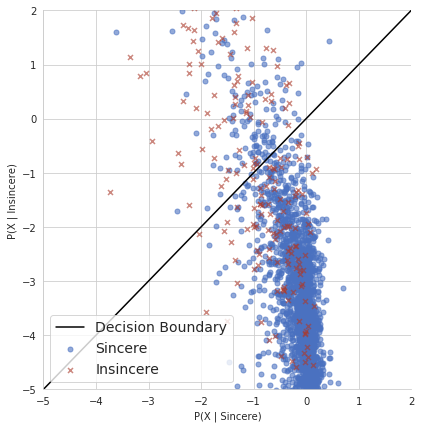

In [16]:
# DATA VISUALIZATION
seaborn.set_style('whitegrid')


# necessary variables
# seaborn works best with dataframes instead of arrays
xAxisLabel = 'P(X | Sincere)'
yAxisLabel = 'P(X | Insincere)'
categoryLabel = 'Actual Category'
colours = ['#4A71C0', '#AB3A2C']
summaryData = pandas.DataFrame({yAxisLabel: jointInsincereStemmedProbability,
                         xAxisLabel: jointSincereStemmedProbability,
                         categoryLabel: yTestStemmed})
decisionBoundary = numpy.linspace(start = -14000, stop = 2, num = 1000)


# plot
chart = seaborn.lmplot(x = xAxisLabel,
               y = yAxisLabel,
               data = summaryData,
               fit_reg = False,
               legend = False,
               scatter_kws = {'alpha': 0.6, 's': 25},
               hue = categoryLabel,
               markers = ['o', 'x'],
               palette = colours, height = 6)
chart.set(ylim = (-5, 2), xlim = (-5, 2))
pyplot.plot(decisionBoundary, decisionBoundary, color = 'black')
pyplot.legend(('Decision Boundary', 'Sincere', 'Insincere'), fontsize=14)
pyplot.show()